In [1]:
import numpy as np
from filterpy.kalman import EnsembleKalmanFilter 
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import time

## Oscillateur harminique


In [19]:
def f(t,X_n,w): #X_n=(x_n,y_n,z_n)
    (u,v)=X_n
    
    f_1 = v
    f_2 =-w**2*u
    return np.array([f_1,f_2])

In [20]:
def RK4_Lorenz(w,X0,N,T): #we have N+1 discretization points

    
    dt=T/N
    
    X = np.zeros( (N+1, len(X0)) )
    T=np.zeros(N+1)
    X[0] = X0
    t=0. #=t_0
    for n in range(1,N+1):
        
        K1=f(t, X[n-1],w)
        K2=f(t+dt/2., X[n-1] + 1./2. * K1 * dt,w)
        K3=f(t+dt/2., X[n-1] + 1./2. * K2 * dt,w)
        K4=f(t+dt, X[n-1]+ K3 * dt,w)
        T[n]=t
        X[n]=X[n-1]+ dt/6.* (K1+2.*K2+2.*K3+K4)
        t+=dt
        
    return X[:,0],X[:,1],T

In [21]:
X_0 = [2,0]


In [22]:
omega = 2
P = 2*np.pi/omega
dt = P/20
T = 3*P
N_t = int(round(T/0.3))
lorenz2=RK4_Lorenz(omega,X_0,N_t,T)

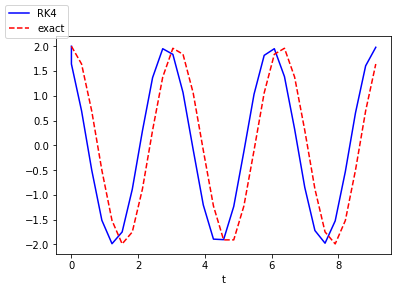

In [23]:
fig = plt.figure()
l1, l2 = plt.plot(lorenz2[2], lorenz2[0], 'b-', lorenz2[2], 2*np.cos(omega*lorenz2[2]), 'r--')
fig.legend((l1, l2), ('RK4', 'exact'), 'upper left')
plt.xlabel('t')
plt.show()

In [24]:

def hx(x):
   return  np.array([x[0]])


def fx(x, dt,w):
    def f(t,X_n,w): #X_n=(x_n,y_n,z_n)
        (u,v)=X_n
        f_1 = v
        f_2 =-w**2*u
        return np.array([f_1,f_2])
    K1=f(t, x,w)
    K2=f(t+dt/2., x + 1./2. * K1 * dt,w)
    K3=f(t+dt/2., x + 1./2. * K2 * dt,w)
    K4=f(t+dt, x+ K3 * dt,w)
    X_next=x+ dt/6.* (K1+2.*K2+2.*K3+K4)
    return X_next

w=2#(σ,b,r)
omega = 2
P = 2*np.pi/omega
T = 3*P
N = int(round(T/0.5))
dt= T/N
x = np.array([2,0])#(x0,y0,z0)
P = np.eye(2) * 2.

f = EnsembleKalmanFilter (x=x, P=P, dim_z=2, dt=dt, N=8,
         hx=hx, fx=lambda x,dt:fx(x,dt,w))

std_noise = np.eye(2)*0.001 
f.R *= std_noise # matrice de cov associer a la mesure
f.Q = Q_discrete_white_noise(2, dt, .01) #bruit blanc centree en 0

def read_sensor(t,omega):
     2*np.cos(omega*t)
t=0
tab_etat=[]
tab_temps=[]
while (t<T):
    z = read_sensor(t,omega)
    f.predict()
    f.update(z)
    tab_etat.append(f.x[0])
    tab_temps.append(t)              
    t=t+dt
print(tab_etat)

[1.3224454765392233, -1.0545657401091226, -2.462780465595581, -1.6618656377616863, 0.6050606311890792, 2.3020333063828975, 1.9212750219710149, -0.17837454357541066, -2.0974185850779423, -2.1219620309930822, -0.25970597827813174, 1.7968544454074988, 2.220319688548013, 0.6592540479032393, -1.4744330268429455, -2.273447701941862, -1.0464857594578303, 1.0927561403545551, 2.2317431744889245, 1.3646533036902435]


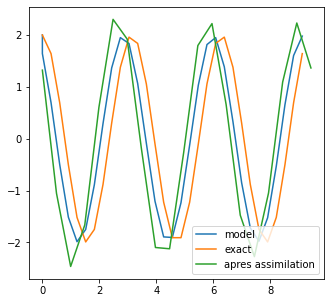

In [25]:
fig=plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,2)
ax1.plot(lorenz2[2],lorenz2[0],label='model')#
ax1.plot(lorenz2[2], 2*np.cos(omega*lorenz2[2]),label='exact')
ax1.plot(tab_temps,tab_etat,label='apres assimilation')
ax1.legend()


## Lorenz

In [26]:
def f(t_n,X_n,σ, b, r): #X_n=(x_n,y_n,z_n)
    (x,y,z)=X_n
    
    f_1 = σ*(y-x)
    f_2 = x*(r-z)-y
    f_3 = x*y-b*z
    return np.array([f_1,f_2,f_3])

In [27]:
def RK4_Lorenz(γ,X0,N,T): #we have N+1 discretization points
    (σ,b,r)=γ
    
    dt=T/N
    
    X = np.zeros( (N+1, len(X0)) )
    T=np.zeros(N+1)
    X[0] = X0
    
    t=0. #=t_0
    for n in range(1,N+1):
        
        K1=f(t, X[n-1],σ,b,r)
        K2=f(t+dt/2., X[n-1] + 1./2. * K1 * dt,σ,b,r)
        K3=f(t+dt/2., X[n-1] + 1./2. * K2 * dt,σ,b,r)
        K4=f(t+dt, X[n-1]+ K3 * dt,σ,b,r)
        T[n]=t
        X[n]=X[n-1]+ dt/6.* (K1+2.*K2+2.*K3+K4)
        t+=dt
        
    return X[:,0],X[:,1],X[:,2],T

In [28]:
γ=(12.,6.,12.) #(σ,b,r)
X0=(-10.,-10.,25.) #(x0,y0,z0)
N=int(5/0.01)
T=5

In [29]:
lorenz1=RK4_Lorenz(γ,X0,N,T)

In [30]:
γ=(11.,6.,11.) #(σ,b,r)
X0=(-10.,-10.,25.) #(x0,y0,z0)
N=int(5/0.1)
T=5

In [31]:
lorenz2=RK4_Lorenz(γ,X0,N,T)

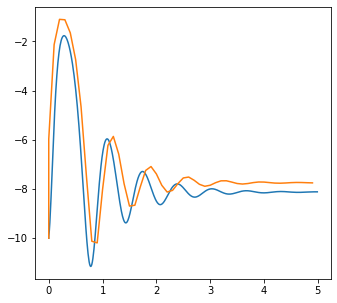

In [32]:
fig=plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,2)
ax1.plot(lorenz1[3],lorenz1[0])
ax1.plot(lorenz2[3],lorenz2[0])

In [33]:
def hx(x):
   return x


def fx(x, dt,σ,b,r):
    def f(t_n,X_n,σ, b, r): #X_n=(x_n,y_n,z_n)
        (x,y,z)=X_n
    
        f_1 = σ*(y-x)
        f_2 = x*(r-z)-y
        f_3 = x*y-b*z
        return np.array([f_1,f_2,f_3])
    K1=f(t, x,σ,b,r)
    K2=f(t+dt/2., x + 1./2. * K1 * dt,σ,b,r)
    K3=f(t+dt/2., x + 1./2. * K2 * dt,σ,b,r)
    K4=f(t+dt, x+ K3 * dt,σ,b,r)
    X_next=x+ dt/6.* (K1+2.*K2+2.*K3+K4)
    return X_next

γ=(11.,6.,10.) #(σ,b,r)
N=10
T=5

x = np.array([-10.,-10.,25.])#(x0,y0,z0)
P = np.eye(3) * 2.
dt= N*0.01
f = EnsembleKalmanFilter (x=x, P=P, dim_z=3, dt=dt, N=8,
         hx=hx, fx=lambda x,dt:fx(x,dt,11.,6.,11.))

std_noise = np.eye(3)*0.001 
f.R *= std_noise # matrice de cov associer a la mesure
f.Q = Q_discrete_white_noise(3, dt, .01) #bruit blanc centree en 0

def read_sensor(index):
    return np.array([lorenz1[0][index],lorenz1[1][index],lorenz1[2][index]])
t=dt  
index=N
tab_etat=[]
tab_temps=[]
while (t<T):
    z = read_sensor(index)
    f.predict()
    f.update(z)
    tab_etat.append(f.x[0])
    tab_temps.append(t)
    index+=N                 
    t=t+dt
print(tab_etat)

[-5.8316924872426865, -2.444239368831346, -1.6614628137495902, -2.0705063568333717, -3.4643966964419763, -6.094043000330735, -9.485478588525439, -10.890030406560177, -8.795141657317043, -6.431775438508701, -5.609997008832606, -6.10468172488164, -7.360433702298391, -8.41709196861849, -8.638535428872146, -7.580237729760358, -6.7032696460621715, -6.478489154415513, -7.013334067400509, -7.6807112994247655, -7.838043103354702, -7.439449803765551, -7.031591874276775, -6.940284951850551, -7.062579875099918, -7.312935291962261, -7.476992799011693, -7.671306406217551, -7.610490655498162, -7.476285801299314, -7.568061060901426, -7.6530908577944246, -7.624168702556684, -7.66899828655975, -7.638249791366562, -7.4869960712765184, -7.321665938869106, -7.335403477876354, -7.414729211185031, -7.25871861143116, -7.361853518017765, -7.412935569701433, -7.457828372386639, -7.474898470831367, -7.549067534158951, -7.6102119441983325, -7.560854698594526, -7.436943091066248, -7.38847433857057, -7.40652183330

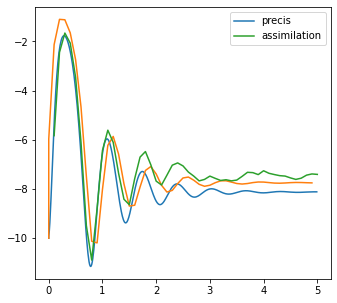

In [35]:
fig=plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,2)
ax1.plot(lorenz1[3],lorenz1[0],label="precis")
ax1.plot(lorenz2[3],lorenz2[0])
ax1.plot(tab_temps,tab_etat,label="assimilation")
ax1.legend()